In [184]:
import pandas as pd
import numpy as np

In [185]:
df = pd.read_csv('data/SBAnational.csv', dtype='unicode')
pd.set_option('display.max_columns', None)
df.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


# Explication de variables

- `DisbursementGross` signifie que plus le montant du prêt est élevé, plus cela signifie que l'entreprise sera établie et en expansion => augmente la probabilité de rembourser le prêt.
- `State` suivant l'Etat dans lequel est contracté le prêt, cela impacte le taux de celui-ci 

<img src="data/state.jpg" />

- `NAICS` les 2 premiers chiffres de cette colonne représente un type d'industrie

|2 digit code|Description|Default rate (%)|
|:----|:----|:----|
|21|Mining, quarrying, and oil and gas extraction|8|
|11|Agriculture, forestry, fishing and hunting|9|
|55|Management of companies and enterprises|10|
|62|Health care and social assistance|10|
|22|Utilities|14|
|92|Public administration|15|
|54|Professional, scientific, and technical services|19|
|42|Wholesale trade|19|
|31–33|Manufacturing|19, 16, 14|
|81|Other services (except public administration)|20|
|71|Arts, entertainment, and recreation|21|
|72|Accommodation and food services|22|
|44–45|Retail trade|22, 23|
|23|Construction|23|
|56|Administrative/support & waste management/remediation Service|24|
|61|Educational services|24|
|51|Information|25|
|48–49|Transportation and warehousing|27, 23|
|52|Finance and insurance|28|
|53|Real estate and rental and leasing|29|

- `NewExist` le fait qu'une entreprise soit nouvelle ou établie. 1 si >= 2 ans, 2 sinon

# Copie pour perf

In [186]:
df_sba = df.copy()
df_sba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   LoanNr_ChkDgt      899164 non-null  object
 1   Name               899150 non-null  object
 2   City               899134 non-null  object
 3   State              899150 non-null  object
 4   Zip                899164 non-null  object
 5   Bank               897605 non-null  object
 6   BankState          897598 non-null  object
 7   NAICS              899164 non-null  object
 8   ApprovalDate       899164 non-null  object
 9   ApprovalFY         899164 non-null  object
 10  Term               899164 non-null  object
 11  NoEmp              899164 non-null  object
 12  NewExist           899028 non-null  object
 13  CreateJob          899164 non-null  object
 14  RetainedJob        899164 non-null  object
 15  FranchiseCode      899164 non-null  object
 16  UrbanRural         8

# nettoyage et formatage des data

In [187]:
def transform_curracy(df, columns):
    for col in columns:
        df[col] = df[col].replace(r'[\$ ,\.]', '', regex=True).astype(float)

def transform_date(df, columns, format='%d-%b-%y'):
    for col in columns:
        try:
            df[col] = pd.to_datetime(df[col], format=format, errors='raise')
        except ValueError:
            print('Erreur sur la date col:', col)
            pass

transform_curracy(df_sba, ['GrAppv', 'DisbursementGross', 'SBA_Appv', 'ChgOffPrinGr'])
transform_date(df_sba, ['ApprovalDate', 'DisbursementDate'])

df_sba.NAICS = df_sba.NAICS.astype(str).str[0:2].astype('category')
df_sba.ApprovalFY = df_sba.ApprovalFY.astype(str).str[0:4].astype(int)
df_sba.Zip = df_sba.Zip.astype(int)
df_sba.Term = df_sba.Term.astype(int)
df_sba.NoEmp = df_sba.NoEmp.astype(int)
df_sba.CreateJob = df_sba.CreateJob.astype(int)
df_sba.RetainedJob = df_sba.RetainedJob.astype(int)
df_sba.FranchiseCode = df_sba.FranchiseCode.astype('category')
df_sba.UrbanRural = df_sba.UrbanRural.astype('category')

df_sba.head(2)

print(df_sba.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      899164 non-null  object        
 1   Name               899150 non-null  object        
 2   City               899134 non-null  object        
 3   State              899150 non-null  object        
 4   Zip                899164 non-null  int64         
 5   Bank               897605 non-null  object        
 6   BankState          897598 non-null  object        
 7   NAICS              899164 non-null  category      
 8   ApprovalDate       899164 non-null  datetime64[ns]
 9   ApprovalFY         899164 non-null  int64         
 10  Term               899164 non-null  int64         
 11  NoEmp              899164 non-null  int64         
 12  NewExist           899028 non-null  object        
 13  CreateJob          899164 non-null  int64   

## drop des colonnes qui ne sont pas utiles

In [188]:
df_sba.drop(columns=['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank'], inplace=True)
df_sba.head(2)

,State,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,IN,OH,45,1997-02-28,1997,84,4,2,0,0,1,0,N,Y,NaN,1999-02-28,6000000.0,$0.00,P I F,0.0,6000000.0,4800000.0
1,IN,IN,72,1997-02-28,1997,60,2,2,0,0,1,0,N,Y,NaN,1997-05-31,4000000.0,$0.00,P I F,0.0,4000000.0,3200000.0


## drop des colonnes fortement corrélées (colinéarité)

In [189]:
df_sba.drop(columns=['CreateJob', 'SBA_Appv'], inplace=True)
# CreateJob avec RetainedJob
# SBA_Appv avec GrAppv

## drop des colonnes target leaking

In [190]:
df_sba.drop(columns=['ChgOffPrinGr', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross'], inplace=True)
df_sba.head(2)

,State,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv
0,IN,OH,45,1997-02-28,1997,84,4,2,0,1,0,N,Y,P I F,6000000.0
1,IN,IN,72,1997-02-28,1997,60,2,2,0,1,0,N,Y,P I F,4000000.0


## OHE de la target

In [191]:
from sklearn.preprocessing import LabelBinarizer

df_sba.dropna(subset=['MIS_Status'], inplace=True)  # Pour tester avant de voir si on fait de l'imputation (1997 nan / 899163 observations)
df_sba.MIS_Status = LabelBinarizer().fit_transform(df_sba.loc[:,['MIS_Status']])
df_sba.MIS_Status = df_sba.MIS_Status.astype(bool)

# display(df_sba.head(2))
# df_sba.info()


In [192]:
df_sba.LowDoc = df_sba.LowDoc.replace(r'[C1SRA0]', np.nan, regex=True)
df_sba.RevLineCr = df_sba.RevLineCr.replace(r'[0T`1C32R7A5\.,4\-Q]', np.nan, regex=True)
df_sba.NewExist = df_sba.NewExist.replace(r'[0]', np.nan, regex=True)


## missing values

<Axes: >

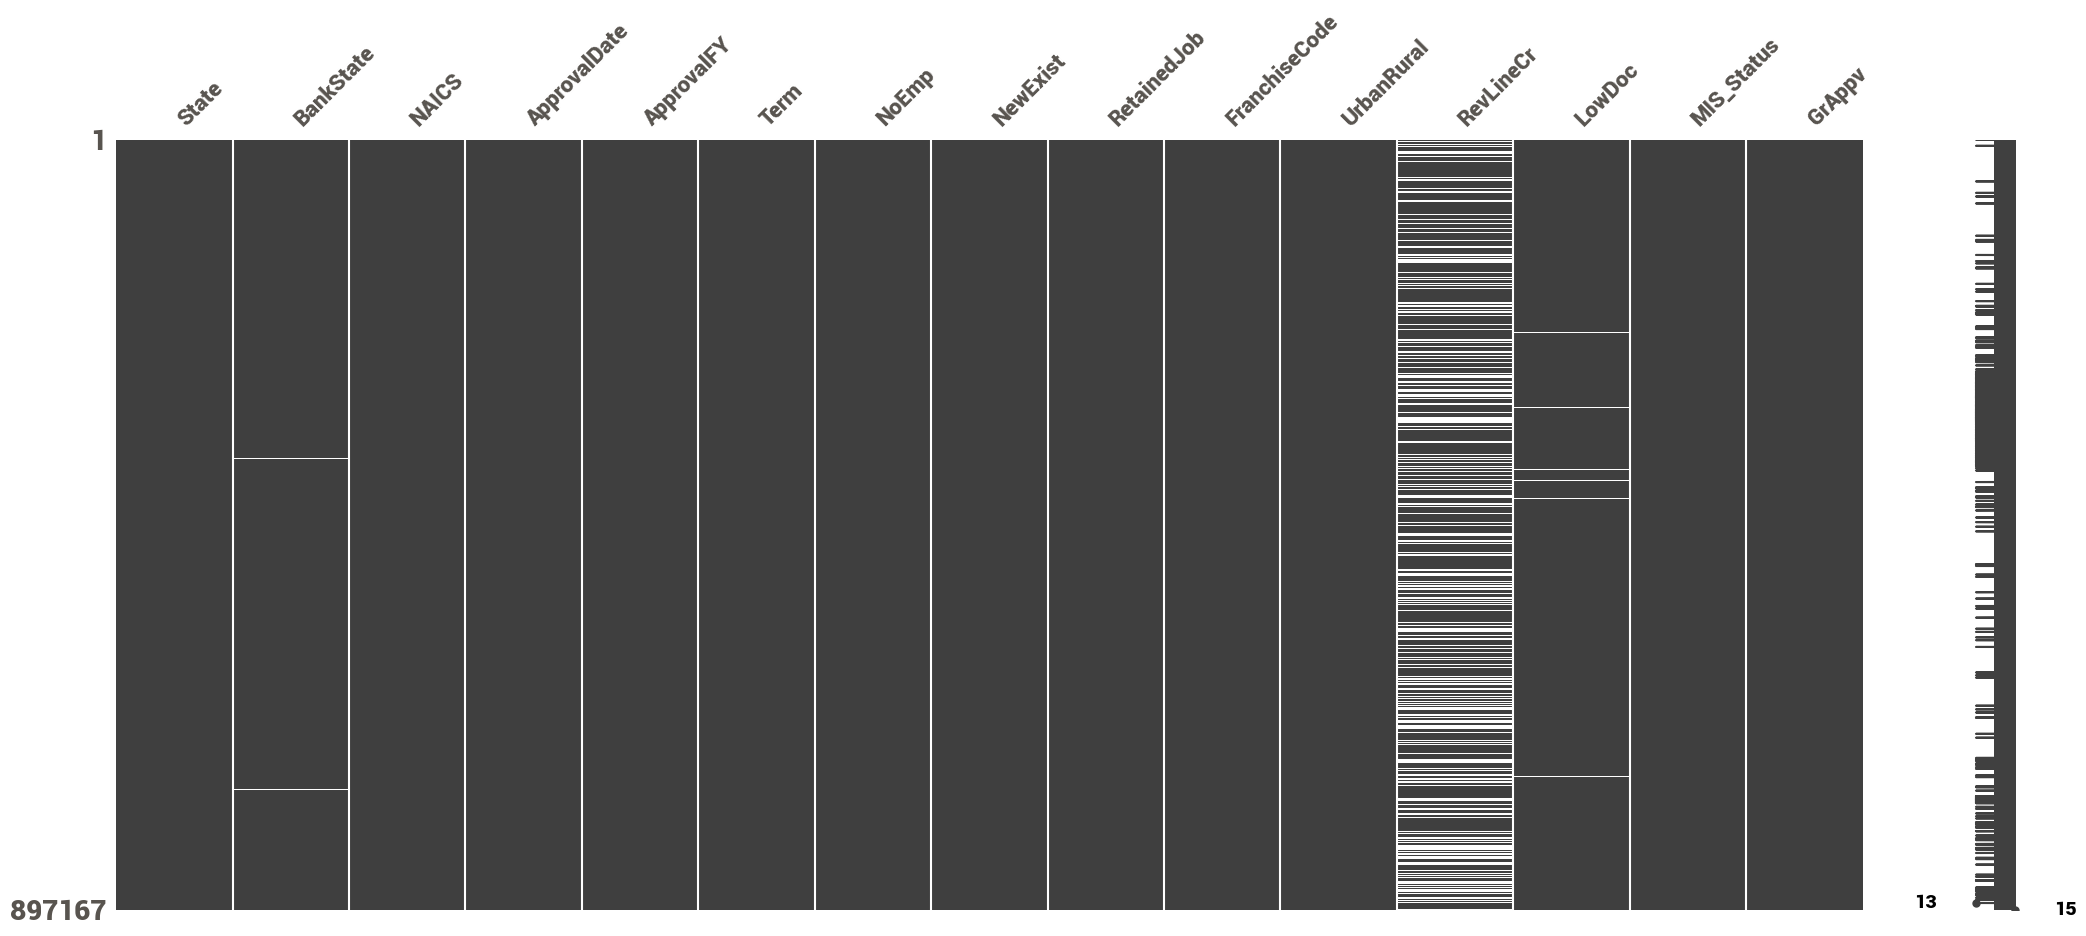

In [193]:
import missingno as msno
msno.matrix(df_sba)

## Imputer
### LowDoc RevLineCr NewExist

<Axes: >

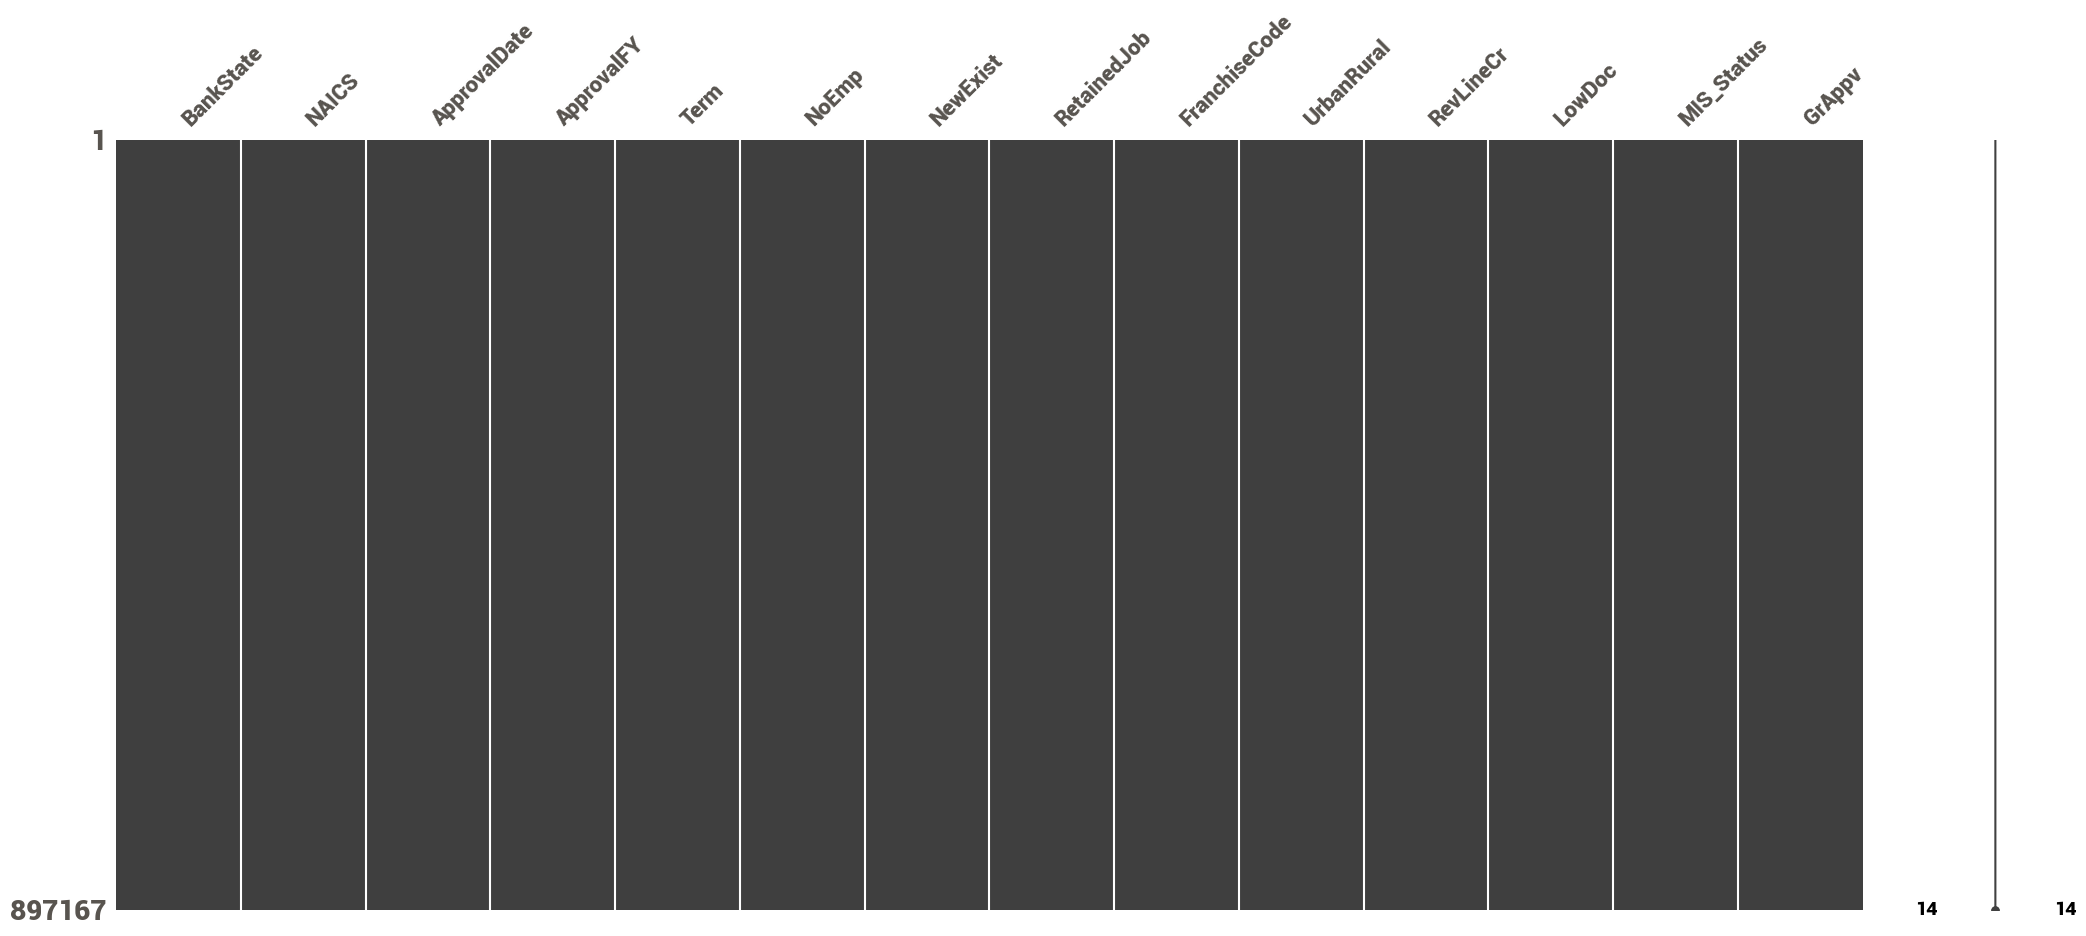

In [194]:
from feature_engine.imputation import RandomSampleImputer
imputer = RandomSampleImputer()
result = imputer.fit_transform(df_sba.loc[:,['LowDoc']])
df_sba.LowDoc = result['LowDoc']
df_sba.LowDoc = LabelBinarizer().fit_transform(df_sba.loc[:,['LowDoc']])
df_sba.LowDoc = df_sba.LowDoc.astype('category')

result = imputer.fit_transform(df_sba.loc[:,['RevLineCr']])
df_sba.RevLineCr = result['RevLineCr']
df_sba.RevLineCr = LabelBinarizer().fit_transform(df_sba.loc[:,['RevLineCr']])
df_sba.RevLineCr = df_sba.RevLineCr.astype('category')

result = imputer.fit_transform(df_sba.loc[:,['NewExist']])
df_sba.NewExist = result['NewExist']
df_sba.NewExist = df_sba.NewExist.astype('category')

# on remplace les na de BankState avec la valeur de State (fortement corrélés)
df_sba.BankState = np.where(df_sba.BankState.isna(), df_sba.State, df_sba.BankState)
# Il en reste 1. City = Pennsville -> New Jersey -> BankState = NJ
df_sba.BankState = np.where(df_sba.BankState.isna(), 'NJ', df_sba.BankState)
# On supprime State
df_sba.drop(columns=['State'], inplace=True)

msno.matrix(df_sba)


In [195]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_sba.BankState = le.fit_transform(df_sba.loc[:,['BankState']])
df_sba.BankState = df_sba.BankState.astype('category')

df_sba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897167 entries, 0 to 899163
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   BankState      897167 non-null  category      
 1   NAICS          897167 non-null  category      
 2   ApprovalDate   897167 non-null  datetime64[ns]
 3   ApprovalFY     897167 non-null  int64         
 4   Term           897167 non-null  int64         
 5   NoEmp          897167 non-null  int64         
 6   NewExist       897167 non-null  category      
 7   RetainedJob    897167 non-null  int64         
 8   FranchiseCode  897167 non-null  category      
 9   UrbanRural     897167 non-null  category      
 10  RevLineCr      897167 non-null  category      
 11  LowDoc         897167 non-null  category      
 12  MIS_Status     897167 non-null  bool          
 13  GrAppv         897167 non-null  float64       
dtypes: bool(1), category(7), datetime64[ns](1), float64(1), i

/Volumes/DD 250/dev/_simplon/US-SBA/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [196]:
import sweetviz as sv
feature_config = sv.FeatureConfig(force_num=["MIS_Status"])

sweet_report = sv.analyze(df_sba, 'MIS_Status')
sweet_report.show_html(filepath='sweetviz_eda/with_imputation.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report sweetviz_eda/with_imputation.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [197]:
# sweet_report = sv.compare_intra(df_sba, df_sba["Bank"] == "BANK OF AMERICA NATL ASSOC", ['BANK OF AMERICA NATL ASSOC', 'Autre'], "MIS_Status", feature_config)
# sweet_report.show_html()